In [2]:
import shelve
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from scipy.optimize import minimize
from skopt import Optimizer, space
from sklearn.model_selection import KFold
from utils import *
from patsy import dmatrices

In [3]:
#initialize dataframe, lines calculated with function to be explained later, xgs extracted from footystats sheets
#season2021 =pd.read_csv("combinefd21.csv")
#season2022 =pd.read_csv("combinefd22.csv")
#season2023 =pd.read_csv("combinefd23.csv")
#df = pd.concat([season2021, season2022, season2023]).reset_index(drop=True)
#print(len(season2021))
#print(len(season2022))
#with shelve.open('inputs') as i:
#    hls = i['hls']
#    als = i['als']
#df.insert(5, 'A_Line', als)
#df.insert(5, 'H_Line', hls)
df = pd.read_csv('all seasons with lines.csv')
df.head(5)

7633
7821


,Div,Date,Time,HomeTeam,AwayTeam,H_Line,A_Line,FTHG,FTAG,HXG,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,SC0,08/01/20,12:30,Aberdeen,Rangers,0.724756,1.770761,0,1,0.67,...,1.78,1.00,1.83,2.02,1.90,2.00,1.94,2.12,1.85,1.99
1,SC0,08/01/20,15:00,Dundee United,St Johnstone,1.094679,1.066453,1,1,1.49,...,1.52,0.00,1.93,1.93,1.91,1.99,2.00,1.99,1.92,1.93
2,SC0,08/01/20,15:00,Hibernian,Kilmarnock,1.511150,0.977880,2,1,1.24,...,1.76,-0.50,1.95,1.90,1.96,1.94,2.02,1.94,1.95,1.88
3,SC0,08/01/20,15:00,St Mirren,Livingston,0.945194,1.182613,1,0,0.94,...,1.53,0.25,1.85,2.00,1.88,2.01,1.90,2.08,1.83,2.01
4,SC0,08/02/20,16:30,Celtic,Hamilton,3.534317,0.420098,5,1,3.07,...,3.79,-3.00,1.98,1.88,2.01,1.88,2.04,1.92,1.96,1.87


Define a method to gather data from the csv and compute metrics that will be trained on

In [4]:
def gather_data(decay): # decay factor used to compute weighted averages for recency
    # dictionaries to store stats for each team
    goals_for = {}
    goals_ag = {}
    xgoals_for = {}
    xgoals_ag = {}
    lines_for = {}
    lines_ag = {}

    # parameter names for the metrics
    param_names = ['goals', 'loglines']
    param_names += ['xgoals_lines_for', 'goals_lines_for', 
                'goals_xgoals_for','wxgoals_lines_for', 
                'wgoals_lines_for', 'wgoals_xgoals_for']
    param_names += ['xgoals_lines_ag', 'goals_lines_ag', 
                    'goals_xgoals_ag','wxgoals_lines_ag', 
                    'wgoals_lines_ag', 'wgoals_xgoals_ag']
    # minimum sample size for teams before betting on a match
    min_sample_size = 8

    # list to store training data rows
    training_rows = []

    # Iterate over each row in the DataFrame
    for index, row in df.iterrows(): 
        if index == 7633 or index == 7633+7821: #new seasons
            goals_for = {}
            goals_ag = {}
            xgoals_for = {}
            xgoals_ag = {}
            lines_for = {}
            lines_ag = {}
            
        home_team = row['HomeTeam']
        away_team = row['AwayTeam']
        h_line = row['H_Line']
        a_line = row['A_Line']
        h_goals = row['FTHG']
        a_goals = row['FTAG']

        # Check if both teams have sufficient data for betting
        if home_team in goals_for and away_team in goals_for and len(goals_for[home_team]) >= min_sample_size and len(goals_for[away_team]) >= min_sample_size and sum(goals_for[home_team])>0 and sum(goals_for[away_team])>0 and sum(goals_ag[home_team])>0 and sum(goals_ag[away_team])>0:

            # Calculate various metrics for home and away teams
            h_xgoals_vs_lines_for, h_goals_vs_lines_for, h_goals_vs_xgoals_for, h_xgoals_vs_lines_ag, h_goals_vs_lines_ag, h_goals_vs_xgoals_ag = metrics(home_team, goals_for, goals_ag, xgoals_for, xgoals_ag, lines_for, lines_ag)
            a_xgoals_vs_lines_for, a_goals_vs_lines_for, a_goals_vs_xgoals_for, a_xgoals_vs_lines_ag, a_goals_vs_lines_ag, a_goals_vs_xgoals_ag = metrics(away_team, goals_for, goals_ag, xgoals_for, xgoals_ag, lines_for, lines_ag)
            weighted_h_xgoals_vs_lines_for, weighted_h_goals_vs_lines_for, weighted_h_goals_vs_xgoals_for, weighted_h_xgoals_vs_lines_ag, weighted_h_goals_vs_lines_ag, weighted_h_goals_vs_xgoals_ag = metrics(home_team, goals_for, goals_ag, xgoals_for, xgoals_ag, lines_for, lines_ag, True, decay)
            weighted_a_xgoals_vs_lines_for, weighted_a_goals_vs_lines_for, weighted_a_goals_vs_xgoals_for, weighted_a_xgoals_vs_lines_ag, weighted_a_goals_vs_lines_ag, weighted_a_goals_vs_xgoals_ag = metrics(away_team, goals_for, goals_ag, xgoals_for, xgoals_ag, lines_for, lines_ag, True, decay)

            # Apply the convert_metric function to each metric for home and away teams
            home_metrics = [h_xgoals_vs_lines_for, h_goals_vs_lines_for, h_goals_vs_xgoals_for, weighted_h_xgoals_vs_lines_for, weighted_h_goals_vs_lines_for, weighted_h_goals_vs_xgoals_for]
            home_metrics += [a_xgoals_vs_lines_ag, a_goals_vs_lines_ag, a_goals_vs_xgoals_ag, weighted_a_xgoals_vs_lines_ag, weighted_a_goals_vs_lines_ag, weighted_a_goals_vs_xgoals_ag]
            away_metrics = [a_xgoals_vs_lines_for, a_goals_vs_lines_for, a_goals_vs_xgoals_for, weighted_a_xgoals_vs_lines_for, weighted_a_goals_vs_lines_for, weighted_a_goals_vs_xgoals_for]
            away_metrics += [h_xgoals_vs_lines_ag, h_goals_vs_lines_ag, h_goals_vs_xgoals_ag, weighted_h_xgoals_vs_lines_ag, weighted_h_goals_vs_lines_ag, weighted_h_goals_vs_xgoals_ag]

            for i in range(12):
                home_metrics[i] = convert_metric(h_line, home_metrics[i])
                away_metrics[i] = convert_metric(a_line, away_metrics[i])

            # Create complete metrics Series for home and away teams
            complete_home_metrics = pd.Series([h_goals, np.log(h_line*1.024)]+home_metrics,index=param_names)
            complete_away_metrics = pd.Series([a_goals, np.log(a_line*1.024)]+away_metrics,index=param_names)

            # Append the metrics Series to the training_rows list
            training_rows.append(complete_home_metrics)
            training_rows.append(complete_away_metrics)

        # Update the dictionaries with new data for goals, expected goals, and lines
        h_xg = row['HXG']
        a_xg = row['AXG']
        if h_xg > 0 and abs(a_xg) > 0:
            goals_for[home_team] = goals_for.setdefault(home_team, [])+[h_goals]
            goals_for[away_team] = goals_for.setdefault(away_team, [])+[a_goals]
            goals_ag[home_team] = goals_ag.setdefault(home_team, [])+[a_goals]
            goals_ag[away_team] = goals_ag.setdefault(away_team, [])+[h_goals]
            xgoals_for[home_team] = xgoals_for.setdefault(home_team, [])+[h_xg]
            xgoals_for[away_team] = xgoals_for.setdefault(away_team, [])+[a_xg]
            xgoals_ag[home_team] = xgoals_ag.setdefault(home_team, [])+[a_xg]
            xgoals_ag[away_team] = xgoals_ag.setdefault(away_team, [])+[h_xg]
            lines_for[home_team] = lines_for.setdefault(home_team, [])+[h_line]
            lines_for[away_team] = lines_for.setdefault(away_team, [])+[a_line]
            lines_ag[home_team] = lines_ag.setdefault(home_team, [])+[a_line]
            lines_ag[away_team] = lines_ag.setdefault(away_team, [])+[h_line]
    return training_rows


In [5]:
# Gather the training data based on the best decay value
training_rows = gather_data(.93)
data = pd.concat(training_rows, axis=1).T

Separate the data into predictors and response

In [6]:
expr = 'goals ~ loglines'
for name in data.columns[2:]:
    expr += ' + '+name
    
y, X = dmatrices(expr, data, return_type='matrix')

Functions also defined in utils but rewritten to facilitate gradient computation, will be added to a module summarizing the key functions used

In [50]:
def gpmf(y, lamb, alpha):
    ay = alpha*y
    lay = lamb+ay
    term = np.exp(-(lay))
    term2 = np.power(lay, y-2)
    fact = factorial(y)

    p = lamb * term * np.power(lay, y-1) / fact

    numerator = -1
    numerator *= term2*(np.power(lamb, 2)+(alpha-1)*y*lamb-ay)*term
    dp_dlamb = numerator / fact

    numerator = -1
    numerator *= lamb*y*term2*(ay-y+lamb+1)*term
    dp_dalpha = numerator / fact

    p = np.where(p <= 0, 1e-8, p)
    p = np.where(p > 1, 1, p)
    return p, dp_dlamb, dp_dalpha

def objective(params, X, y, grad=False):
    params = params.reshape(-1, 1)
    beta1 = np.array(params[:14])
    beta2 = np.array(params[14:])
    lamb = np.exp(X @ beta1)
    tan = np.tanh(X @ beta2)
    alpha = tan*.1-.024

    p, dp_dlamb, dp_dalpha = gpmf(y, lamb, alpha)
    if grad:
        dloss_dp = -1/p
        dlamb_dbeta1 = lamb*X
        dalpha_dbeta2 = (1-np.power(tan, 2)) * .1 * X

        dloss_dbeta1 = dloss_dp * dp_dlamb * dlamb_dbeta1
        dloss_dbeta2 = dloss_dp * dp_dalpha * dalpha_dbeta2
        jac1 = np.mean(dloss_dbeta1.T, axis=1)
        jac2 = np.mean(dloss_dbeta2.T, axis=1)
        jac = np.hstack((jac1, jac2))
    return -np.mean(np.log(p)), jac

Start without L1/L2 regularization. Borrow from neural nets and incorporate early stopping across the scipy.minimize methods to determine optimal number of iterations. To be cleaned up for module

In [7]:
kf = KFold(n_splits=10)  # Define the number of folds
cv_losses = {}
methods = ['nelder-mead', 'powell', 'cg', 'bfgs', 'newton-cg', 'l-bfgs-b', 'tnc', 'cobyla', 'slsqp', 'trust-constr']
for method in methods:
    cv_losses[method] = {}
    for i in range(1, 1001):
        cv_losses[method][i] = []
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    score = {}
    results = {}
    
    for method in methods:
        progress = {'start_time': time.time(), 'iters':0, 'iters_since_improvement':0, 'best_cv':float('inf'), 'best_iter': None, 'best_params': None}
        def callback(xk,state=None):
            cv_loss = objective(xk, X_val, y_val)[0]
            cv_losses[method][progress['iters']+1].append(cv_loss)
            if cv_loss < progress['best_cv']:
                progress['best_cv'] = cv_loss
                progress['iters_since_improvement'] = 0
                progress['best_iter'] = progress['iters'] + 1
                progress['best_params'] = xk
            else:
                progress['iters_since_improvement'] += 1
                if progress['iters'] > 100 and progress['iters_since_improvement'] > (progress['iters']+1)*.8:
                    raise Exception("Cross validation showing no signs of improving")
            if time.time() - progress['start_time'] > 20:
                raise Exception("Timeout")

            progress['iters'] += 1
        params = np.array([0, 1]+[0]*26).T
        try:
            result = minimize(objective, params, args=(X_train,y_train), method=method, jac=True, callback=callback, options={'maxiter': 1000})
        except Exception as e:
            pass
            # Exception handling code
            print("Optimization terminated:", str(e))
        #print(method, progress['best_cv'])
        score[method] = progress['best_cv']
        results[method] = progress
  

C:\anaconda3\lib\site-packages\scipy\optimize\_minimize.py:550: RuntimeWarning: Method nelder-mead does not use gradient information (jac).
  warn('Method %s does not use gradient information (jac).' % method,


Optimization terminated: Cross validation showing no signs of improving


C:\anaconda3\lib\site-packages\scipy\optimize\_minimize.py:550: RuntimeWarning: Method powell does not use gradient information (jac).
  warn('Method %s does not use gradient information (jac).' % method,


Optimization terminated: Cross validation showing no signs of improving
Optimization terminated: Cross validation showing no signs of improving
Optimization terminated: Timeout
Optimization terminated: Cross validation showing no signs of improving


C:\Users\Bryant Ndongmo\AppData\Local\Temp\ipykernel_11724\13555808.py:35: DeprecationWarning: 'maxiter' has been deprecated in favor of 'maxfun' and will be removed in SciPy 1.11.0.
  result = minimize(objective, params, args=(X_train,y_train), method=method, jac=True, callback=callback, options={'maxiter': 1000})
C:\anaconda3\lib\site-packages\scipy\optimize\_minimize.py:550: RuntimeWarning: Method cobyla does not use gradient information (jac).
  warn('Method %s does not use gradient information (jac).' % method,


Optimization terminated: Timeout
Optimization terminated: Cross validation showing no signs of improving
Optimization terminated: Cross validation showing no signs of improving
Optimization terminated: Cross validation showing no signs of improving
Optimization terminated: Cross validation showing no signs of improving
Optimization terminated: Cross validation showing no signs of improving
Optimization terminated: Cross validation showing no signs of improving
Optimization terminated: Cross validation showing no signs of improving
Optimization terminated: Cross validation showing no signs of improving
Optimization terminated: Timeout
Optimization terminated: Timeout
Optimization terminated: Cross validation showing no signs of improving
Optimization terminated: Cross validation showing no signs of improving
Optimization terminated: Cross validation showing no signs of improving
Optimization terminated: Cross validation showing no signs of improving
Optimization terminated: Cross valida

C:\Users\Bryant Ndongmo\AppData\Local\Temp\ipykernel_11724\13555808.py:35: DeprecationWarning: 'maxiter' has been deprecated in favor of 'maxfun' and will be removed in SciPy 1.11.0.
  result = minimize(objective, params, args=(X_train,y_train), method=method, jac=True, callback=callback, options={'maxiter': 1000})
C:\anaconda3\lib\site-packages\scipy\optimize\_minimize.py:550: RuntimeWarning: Method cobyla does not use gradient information (jac).
  warn('Method %s does not use gradient information (jac).' % method,


Optimization terminated: Timeout
Optimization terminated: Cross validation showing no signs of improving


C:\anaconda3\lib\site-packages\scipy\optimize\_minimize.py:550: RuntimeWarning: Method nelder-mead does not use gradient information (jac).
  warn('Method %s does not use gradient information (jac).' % method,


Optimization terminated: Cross validation showing no signs of improving


C:\anaconda3\lib\site-packages\scipy\optimize\_minimize.py:550: RuntimeWarning: Method powell does not use gradient information (jac).
  warn('Method %s does not use gradient information (jac).' % method,


Optimization terminated: Timeout
Optimization terminated: Cross validation showing no signs of improving
Optimization terminated: Cross validation showing no signs of improving
Optimization terminated: Cross validation showing no signs of improving
Optimization terminated: Cross validation showing no signs of improving
Optimization terminated: Cross validation showing no signs of improving
Optimization terminated: Cross validation showing no signs of improving
Optimization terminated: Cross validation showing no signs of improving
Optimization terminated: Cross validation showing no signs of improving
Optimization terminated: Cross validation showing no signs of improving
Optimization terminated: Cross validation showing no signs of improving
Optimization terminated: Cross validation showing no signs of improving
Optimization terminated: Timeout
Optimization terminated: Cross validation showing no signs of improving
Optimization terminated: Cross validation showing no signs of improvin

Determine the best average cv loss with method and number of iterations. Appears bfgs with 51 iterations is best

In [8]:
best_loss = np.inf
for method in methods:
    for i in range(1,1001):
        l = cv_losses[method][i]
        if len(l) == 10:
            loss = sum(l)/10
            if loss <= best_loss:
                best_loss = loss
            if loss <= 1.4145:
                print(method, i, loss)

print(cv_losses['bfgs'][51])

cg 14 1.41448252076091
cg 22 1.4144885978499997
cg 23 1.4144814265807233
cg 38 1.4144964544980958
cg 53 1.4144966321584778
cg 58 1.4144977384178583
cg 60 1.4144893671254724
cg 61 1.4144849000193052
cg 62 1.4144891457371125
cg 63 1.4144917642044572
cg 66 1.4144949944857736
bfgs 48 1.4144966441185165
bfgs 49 1.4144814235686818
bfgs 50 1.4144567918366358
bfgs 51 1.4144311578221749
bfgs 52 1.4144327294441514
bfgs 53 1.4144482682950255
bfgs 54 1.414457640644838
bfgs 55 1.414459758004704
bfgs 56 1.414461444814271
bfgs 57 1.414463786056896
bfgs 58 1.4144675250932544
bfgs 59 1.414473941976755
bfgs 60 1.4144855537382799
l-bfgs-b 23 1.4144856490140374
l-bfgs-b 24 1.4144691826015572
l-bfgs-b 25 1.4144412900974142
l-bfgs-b 26 1.4144523091555574
l-bfgs-b 27 1.4144616246022852
l-bfgs-b 28 1.414456234699404
l-bfgs-b 29 1.4144689100542387
l-bfgs-b 30 1.414467789090414
l-bfgs-b 31 1.4144679442153003
l-bfgs-b 32 1.414474103248982
l-bfgs-b 33 1.4144810092662137
l-bfgs-b 34 1.4144877157125508
trust-constr

In [37]:
#cg, bfgs, l-bfgs-b, trust-constr seem to be best, time to introduce L1/L2 regularization
def objective_regularized(params, X, y, l1_wt1=0, l2_wt1=0, l1_wt2=0, l2_wt2=0):
    params = params.reshape(-1, 1)
    beta1 = np.array(params[:14])
    beta2 = np.array(params[14:])
    lamb = np.exp(X @ beta1)
    tan = np.tanh(X @ beta2)
    alpha = tan*.1-.024

    p, dp_dlamb, dp_dalpha = gpmf(y, lamb, alpha)

    dloss_dp = -1/p
    dlamb_dbeta1 = lamb*X
    dalpha_dbeta2 = (1-np.power(tan, 2)) * .1 * X

    dloss_dbeta1 = dloss_dp * dp_dlamb * dlamb_dbeta1
    dloss_dbeta2 = dloss_dp * dp_dalpha * dalpha_dbeta2
    jac1 = np.mean(dloss_dbeta1.T+l1_wt1*np.sign(beta1)+l2_wt1*2*beta1, axis=1)
    jac2 = np.mean(dloss_dbeta2.T+l1_wt2*np.sign(beta2)+l2_wt2*2*beta2, axis=1)
    jac = np.hstack((jac1, jac2))
    
    adj1 = abs(beta1[1]-1)-abs(beta1[1])
    adj2 = (beta1[1]-1)**2-beta1[1]**2
    l1_penalty = l1_wt1*(np.linalg.norm(beta1, ord=1)+adj1)+l1_wt2*np.linalg.norm(beta2, ord=1)
    l2_penalty = l1_wt2*(np.linalg.norm(beta1, ord=2)**2+adj2)+l2_wt2*np.linalg.norm(beta2, ord=2)**2
    
    return -np.mean(np.log(p)) + l1_penalty + l2_penalty, jac


Function that takes in parameters to test multiple methods with given l1/l2 regularization weights and carry out early stopping to determine performance of method, iteration, penalty combo.

In [17]:
methods = ['cg', 'bfgs', 'l-bfgs-b','trust-constr']
def cross_validate(X, y, l1_wt_1, l2_wt_1, l1_wt_2, l2_wt_2, splits=10, methods = ['cg', 'bfgs', 'l-bfgs-b','trust-constr'], min_iter= 60, max_iter=1000, patience=.8, timeout=20, best_loss=float('inf')):
    kf = KFold(n_splits=splits)  # Define the number of folds
    cv_losses = {}
    for method in methods:
        cv_losses[method] = {}
        for i in range(1, max_iter+1):
            cv_losses[method][i] = []
    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        score = {}
        results = {}

        for method in methods:
            progress = {'start_time': time.time(), 'iters':0, 'iters_since_improvement':0, 'best_cv':float('inf'), 'best_iter': None, 'best_params': None}
            def callback(xk,state=None):
                cv_loss = objective(xk, X_val, y_val)[0]
                cv_losses[method][progress['iters']+1].append(cv_loss)
                if cv_loss < progress['best_cv']:
                    progress['best_cv'] = cv_loss
                    progress['iters_since_improvement'] = 0
                    progress['best_iter'] = progress['iters'] + 1
                    progress['best_params'] = xk
                else:
                    progress['iters_since_improvement'] += 1
                    if progress['iters'] > min_iter and progress['iters_since_improvement'] > (progress['iters']+1)*patience:
                        raise Exception("Cross validation showing no signs of improving")
                if time.time() - progress['start_time'] > timeout:
                    raise Exception("Timeout")

                progress['iters'] += 1
            params = np.array([0, 1]+[0]*26).T
            try:
                result = minimize(objective_regularized, params, args=(X_train,y_train,l1_wt_1, l2_wt_1, l1_wt_2, l2_wt_2), method=method, jac=True, callback=callback, options={'maxiter': 1000})
            except Exception as e:
                pass
                # Exception handling code
                #print("Optimization terminated:", str(e))
            score[method] = progress['best_cv']
            results[method] = progress
            #print(method, score[method])
    for method in methods:
        for i in range(1,max_iter+1):
            l = cv_losses[method][i]
            if len(l) == splits:
                loss = sum(l)/splits
                if loss <= best_loss:
                    #print(method, i, loss)
                    best_loss = loss
                    best = (method, i)
    return best_loss, best


In [19]:
bayes_result = {}
def bayes_objective(x):
    l1_wt_1, l2_wt_1, l1_wt_2, l2_wt_2 = x
    cv = cross_validate(X, y, l1_wt_1, l2_wt_1, l1_wt_2, l2_wt_2)
    bayes_result[tuple(x)] = cv[1]
    return cv[0]




sp = [space.Real(1e-10, .001, name='l1_wt_1', prior='log-uniform'), space.Real(1e-10, .1, name='l2_wt_1', prior='log-uniform')]
sp += [space.Real(1e-10, .001, name='l1_wt_2', prior='log-uniform'), space.Real(1e-10, 1, name='l2_wt_2', prior='log-uniform')]

# Create an instance of Optimizer for Bayesian optimization and optimize
optimizer = Optimizer(sp, base_estimator='gp')

# Set the desired timeout in seconds
timeout_seconds = 3600 * 10 # 10 hours

# Perform Bayesian optimization iterations with timeout
start_time = time.time()
elapsed_time = 0
iters_since_improvement = 0
iters = 0
best_loss = np.inf
best = None
while iters < 60 or iters_since_improvement > .2 * iters:
    optimizer.run(bayes_objective, n_iter=1)  # Run a single iteration
    Xi = optimizer.Xi
    yi = optimizer.yi
    if yi[-1] < best_loss:
        best_loss = yi[-1]
        best = (tuple(Xi[-1]), bayes_result[tuple(Xi[-1])])
        print(best, best_loss)
        iters_since_improvement = 0
    else:
        iters_since_improvement += 1
    iters += 1
    

((4.239409459284336e-09, 4.2828433177175073e-07, 3.312701637144262e-07, 3.004915120543764e-09), ('bfgs', 51)) 1.4144314690562643
((5.559928228152292e-05, 3.2694549621703335e-10, 1.0544385116905289e-08, 9.597776031038723e-08), ('trust-constr', 43)) 1.4144195519707425
((5.396718822844268e-05, 5.008739999507359e-07, 1e-10, 1e-10), ('trust-constr', 46)) 1.414418936660207


In [20]:
print(iters, iters_since_improvement)

60 10


In [21]:
print(yi)

[1.4144314690562643, 1.4144750171604252, 1.414431950844678, 1.4146699896205046, 1.4144195519707425, 1.414431223654621, 1.4144701537634776, 1.4144608438034143, 1.4146699896205046, 1.414440352616458, 1.4144313633518546, 1.4145594331844353, 1.4144226499638646, 1.414502349619847, 1.4145011836892192, 1.4144311585187468, 1.4145288947799417, 1.4146699896205046, 1.4144451531336388, 1.4144250921408401, 1.4144357210530596, 1.4145512483953038, 1.4146699896205046, 1.4145434548546838, 1.4144954755184773, 1.4144311384459856, 1.41449249307322, 1.4145545482127182, 1.4145105663959547, 1.4145644057011943, 1.4144321435300502, 1.414515618646807, 1.4145338438707298, 1.4145119443830194, 1.4145754485520399, 1.4144684165543642, 1.4144312174652836, 1.4144785295770945, 1.414431937302634, 1.41443123766918, 1.4145925643005763, 1.4146699896205046, 1.4144314851325108, 1.4144311166259054, 1.414441313310905, 1.414554496974795, 1.4144311694618894, 1.4144474667419493, 1.4146176857883916, 1.414418936660207, 1.4144243613

In [31]:
params = np.array([0, 1]+[0]*26).T
print(objective(params, X, y)[0]-best_loss)
result = minimize(objective_regularized, params, args=(X,y, 5.396718822844268e-05, 5.008739999507359e-07, 1e-10, 1e-10), method='trust-constr', jac=True, options={'maxiter':46})
print(result)


0.0002510529602979261
         cg_niter: 178
     cg_stop_cond: 4
           constr: []
      constr_nfev: []
      constr_nhev: []
      constr_njev: []
   constr_penalty: 1.0
 constr_violation: 0
   execution_time: 1.0835003852844238
              fun: 1.4140303826321499
             grad: array([-4.67840073e-05, -3.29137596e-05, -7.00177878e-06, -8.03946151e-05,
       -1.02562833e-04, -5.92857657e-06,  1.21595170e-04,  6.26374150e-05,
       -1.12943171e-05,  3.95513064e-05,  8.59430520e-05, -1.41808961e-05,
       -2.49413476e-04, -2.37622610e-04,  1.75049122e-04,  1.78455144e-04,
        2.38380942e-05,  6.22859190e-05,  2.93887296e-06,  1.42446421e-05,
        7.75149296e-05,  3.88841193e-05,  1.40122925e-05,  7.19264779e-05,
        3.43156329e-05,  2.96321357e-05, -2.20093079e-05, -7.94260777e-05])
              jac: []
  lagrangian_grad: array([-4.67840073e-05, -3.29137596e-05, -7.00177878e-06, -8.03946151e-05,
       -1.02562833e-04, -5.92857657e-06,  1.21595170e-04,  6.2637

In [36]:
best_params = result.x
beta1 = best_params[:14]
beta2 = best_params[14:]
print(beta1, beta2)
lambdas = np.exp(X@beta1)
alphas = np.tanh(X@beta2)*.1-.024
print(lambdas, alphas)
print(X[np.argmax(alphas)])
print(lambdas[np.argmax(alphas)])
print(y[np.argmax(alphas)])
print()

[-0.0581461   1.1085918  -0.12619399 -0.11757163  0.128275    0.30192025
  0.05176073 -0.13988686  0.06948751  0.03751725  0.02978546 -0.01349286
 -0.13190465  0.00250421] [ 0.18706462 -0.41014269 -0.05984026  0.00235433  0.17202039 -0.01564156
  0.00887062  0.11573496 -0.02840494 -0.0686047   0.04306836 -0.06269881
  0.04709681  0.19721624]
[1.06646007 0.98612724 1.14846826 ... 1.76232645 1.82998954 1.10818671] [-0.01262578 -0.03233223 -0.03919247 ... -0.02632062 -0.04241146
 -0.014383  ]
[ 1.         -1.29141164  0.45068298  0.49862778  0.40661941  0.37174072
  0.32678337  0.2670287   0.35656678 -0.19429482 -0.2503565   0.2650725
 -0.22687692 -0.19009439]
0.24040447221865505
[0.]


In [39]:
# keep going, increase patience, messed up the inequality, fixed
while iters < 60 or iters_since_improvement <= .8 * iters:
    optimizer.run(bayes_objective, n_iter=1)  # Run a single iteration
    Xi = optimizer.Xi
    yi = optimizer.yi
    if yi[-1] < best_loss:
        best_loss = yi[-1]
        best = (tuple(Xi[-1]), bayes_result[tuple(Xi[-1])])
        print(best, best_loss)
        iters_since_improvement = 0
    else:
        iters_since_improvement += 1
    iters += 1


((2.125243357620127e-06, 4.0994588896114135e-06, 2.237433025163467e-08, 3.228076038923881e-08), ('cg', 42)) 1.4144186334557831


C:\Users\Bryant Ndongmo\AppData\Roaming\Python\Python39\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Bryant Ndongmo\AppData\Roaming\Python\Python39\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


((4.966463516121441e-06, 3.2002355458929274e-07, 5.101425463561947e-07, 4.4040564811717414e-08), ('trust-constr', 39)) 1.4144137887514072
((2.129659009089934e-05, 3.606379053118981e-09, 2.669318106640796e-10, 3.278608492851997e-07), ('trust-constr', 47)) 1.414407831826694


C:\Users\Bryant Ndongmo\AppData\Roaming\Python\Python39\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Bryant Ndongmo\AppData\Roaming\Python\Python39\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Bryant Ndongmo\AppData\Roaming\Python\Python39\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


KeyboardInterrupt: 

In [47]:
#check intermediate solution
print(iters, iters_since_improvement)
params = np.array([0, 1]+[0]*26).T
print(objective(params, X, y)[0]-best_loss)
result = minimize(objective_regularized, params, args=(X,y,2.129659009089934e-05, 3.606379053118981e-09, 2.669318106640796e-10, 3.278608492851997e-07), method='trust-constr', jac=True, options={'maxiter':47})
print(result)


415 168
0.000262157793810891
         cg_niter: 164
     cg_stop_cond: 4
           constr: []
      constr_nfev: []
      constr_nhev: []
      constr_njev: []
   constr_penalty: 1.0
 constr_violation: 0
   execution_time: 1.243955373764038
              fun: 1.413990891651976
             grad: array([-1.41723382e-04, -2.83695710e-04,  2.35550083e-05,  3.20191018e-05,
       -3.85653630e-05, -4.31661904e-05,  1.58580175e-06,  1.81290459e-05,
       -2.26991995e-05,  2.86218851e-05,  6.30041646e-05, -3.04244397e-06,
       -9.25501738e-05, -1.09449511e-04,  6.39501560e-05,  7.59594636e-05,
        5.63698790e-05,  6.59251034e-05, -2.18425300e-05,  4.84128680e-05,
        6.84446543e-05, -9.49553321e-07,  4.12513479e-05,  8.62588716e-05,
        2.66892165e-05,  5.39396417e-05,  1.31027317e-06, -7.46614323e-05])
              jac: []
  lagrangian_grad: array([-1.41723382e-04, -2.83695710e-04,  2.35550083e-05,  3.20191018e-05,
       -3.85653630e-05, -4.31661904e-05,  1.58580175e-06,  1

In [ ]:
# think patience .5 is good
while iters < 60 or iters_since_improvement <= .5 * iters:
    optimizer.run(bayes_objective, n_iter=1)  # Run a single iteration
    Xi = optimizer.Xi
    yi = optimizer.yi
    if yi[-1] < best_loss:
        best_loss = yi[-1]
        best = (tuple(Xi[-1]), bayes_result[tuple(Xi[-1])])
        print(best, best_loss)
        iters_since_improvement = 0
    else:
        iters_since_improvement += 1
    iters += 1


((1.8538560054940012e-06, 5.230241397255493e-05, 8.194542657522409e-07, 4.510245535853731e-06), ('cg', 40)) 1.4143978159067125


C:\Users\Bryant Ndongmo\AppData\Roaming\Python\Python39\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Bryant Ndongmo\AppData\Roaming\Python\Python39\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Bryant Ndongmo\AppData\Roaming\Python\Python39\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Bryant Ndongmo\AppData\Roaming\Python\Python39\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


In [13]:
#Final solution
params = np.array([0, 1]+[0]*26).T
result = minimize(objective_regularized, params, args=(X,y,1.8538560054940012e-06, 5.230241397255493e-05, 8.194542657522409e-07, 4.510245535853731e-06), method='cg', jac=True, options={'maxiter':40})
param_names = ['intercept', 'loglines']
param_names += ['xgoals_lines_for', 'goals_lines_for', 
            'goals_xgoals_for','wxgoals_lines_for', 
            'wgoals_lines_for', 'wgoals_xgoals_for']
param_names += ['xgoals_lines_ag', 'goals_lines_ag', 
                'goals_xgoals_ag','wxgoals_lines_ag', 
                'wgoals_lines_ag', 'wgoals_xgoals_ag']
print(result)

     fun: 1.4140171673547357
     jac: array([ 1.60818655e-03,  9.11761236e-04,  1.68561855e-04,  1.62857393e-04,
       -1.02858986e-04, -2.37427906e-05,  9.01219239e-05,  7.15965542e-05,
        4.96687570e-05, -1.86547106e-04, -3.02006011e-04,  1.25986205e-04,
       -1.16683193e-04, -3.31531921e-04,  8.12020736e-05,  2.00403732e-04,
        6.96726538e-05,  5.03742600e-05, -6.44933615e-05,  5.24889351e-05,
        5.36279625e-05, -3.34018961e-05,  4.84577172e-05,  6.02152525e-05,
       -2.06689912e-05,  6.28381656e-05, -1.14768483e-05, -1.11378601e-04])
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 75
     nit: 40
    njev: 75
  status: 1
 success: False
       x: array([-4.62319386e-02,  1.09529993e+00, -8.10055683e-02, -6.15535437e-02,
        9.38547919e-02,  2.04022371e-01,  3.82601271e-02, -1.38517403e-01,
        5.79986228e-02,  2.44191826e-02,  4.11575600e-03, -4.76232303e-02,
       -9.72798389e-02,  4.99641666e-03,  9.32562650e-02, -3.10782439e-01

In [27]:
best_params = result.x
beta1 = np.array(best_params[:14])
beta2 = np.array(best_params[14:])

print('Coefficients for lambda')
lambda_coefs = pd.DataFrame()
lambda_coefs['Parameter'] = param_names
lambda_coefs['Coef'] = beta1
print(lambda_coefs)

print()

print('Coefficients for alpha')
alpha_coefs = pd.DataFrame()
alpha_coefs['Parameter'] = param_names
alpha_coefs['Coef'] = beta2
print(alpha_coefs)

print()

print('Sorted coefficients for lambda')
print(lambda_coefs.iloc[lambda_coefs['Coef'].abs().argsort()[::-1]])

print()

print('Sorted coefficients for alpha')
print(alpha_coefs.iloc[alpha_coefs['Coef'].abs().argsort()[::-1]])



Coefficients for lambda
            Parameter      Coef
0           intercept -0.046232
1            loglines  1.095300
2    xgoals_lines_for -0.081006
3     goals_lines_for -0.061554
4    goals_xgoals_for  0.093855
5   wxgoals_lines_for  0.204022
6    wgoals_lines_for  0.038260
7   wgoals_xgoals_for -0.138517
8     xgoals_lines_ag  0.057999
9      goals_lines_ag  0.024419
10    goals_xgoals_ag  0.004116
11   wxgoals_lines_ag -0.047623
12    wgoals_lines_ag -0.097280
13   wgoals_xgoals_ag  0.004996

Coefficients for alpha
            Parameter      Coef
0           intercept  0.093256
1            loglines -0.310782
2    xgoals_lines_for  0.008716
3     goals_lines_for  0.040250
4    goals_xgoals_for  0.096515
5   wxgoals_lines_for  0.033339
6    wgoals_lines_for  0.045526
7   wgoals_xgoals_for  0.068853
8     xgoals_lines_ag  0.015126
9      goals_lines_ag  0.002347
10    goals_xgoals_ag  0.040170
11   wxgoals_lines_ag -0.000641
12    wgoals_lines_ag  0.057332
13   wgoals_xgoals_ag  0

Get Predictions

In [36]:
model_lamb = np.exp(X@beta1)
model_alpha = np.tanh(X@beta2)*.1-.024
model_preds = model_lamb/(1-model_alpha)

null_params = np.array([0, 1]+[0]*26).T
null_beta1 = null_params[:14]
null_beta2 = null_params[14:]
null_lamb = np.exp(X@null_beta1)
null_alpha = np.tanh(X@null_beta2)*.1-.024
null_preds = null_lamb/(1-null_alpha)

predictions = pd.DataFrame()
predictions['Null Lambda'] = null_lamb
predictions['Model Lambda'] = model_lamb
predictions['Null Alpha'] = null_alpha
predictions['Model Alpha'] = model_alpha
predictions['Null Prediction'] = null_preds
predictions['Model Prediction'] = model_preds
predictions['Goals'] = data['goals']
predictions

,Null Lambda,Model Lambda,Null Alpha,Model Alpha,Null Prediction,Model Prediction,Goals
0,1.079527,1.076298,-0.024,-0.020297,1.054226,1.054888,2.0
1,0.949978,0.985569,-0.024,-0.030603,0.927713,0.956304,0.0
2,1.094548,1.142372,-0.024,-0.034942,1.068895,1.103803,0.0
3,1.373471,1.371363,-0.024,-0.025032,1.341280,1.337874,1.0
4,0.681730,0.679763,-0.024,-0.031761,0.665752,0.658837,1.0
...,...,...,...,...,...,...,...
36475,1.904947,1.941786,-0.024,-0.032600,1.860299,1.880482,2.0
36476,1.897266,1.844239,-0.024,-0.022457,1.852799,1.803732,2.0
36477,1.707834,1.759997,-0.024,-0.026602,1.667807,1.714391,0.0
36478,1.760862,1.833753,-0.024,-0.039223,1.719591,1.764542,1.0


Let's analyze the significance of the model's cross validation performance. We will create a set of rv_discrete variables and define loss distributions based on the null model and compare with alternative performance

In [67]:
from scipy.stats import rv_discrete
# Function to create distributions and losses
def create_dists(null_lamb, pred_lamb, pred_alpha):
    dists = []  # List to store probability distributions
    diffs = []  # List to store diffs

    # Iterate over lines and preds
    for nl, pl, pa in zip(null_lamb, pred_lamb, pred_alpha):
        probs = []  # List to store individual probabilities
        diff = []  # List to store individual losses
        i = 0
        cum = 0.0
        model_cum = 0.0
        
        # Calculate probabilities and losses until cumulative probability exceeds 0.9999
        while cum < 0.9999:
            pmf = gpmf(i, nl, -.024)[0]  # Calculate the probability mass function
            pmf_item = pmf.item()  # Extract the value of the probability mass function
            cum += pmf_item  # Update the cumulative probability
            probs.append(pmf_item)  # Append the probability to the list of probabilities
            null_loss = -np.log(pmf_item)
            
            model_pmf = gpmf(i, pl, pa)[0].item()
            model_cum += model_pmf
            model_loss = -np.log(model_pmf)
            
            diff.append(model_loss-null_loss)  # Append the performance difference to the list of diffs
            i += 1

        dists.append(probs + [1.0 - cum])  # Append the probabilities with the remaining probability to the dists list
        diffs.append(diff + [np.log(1.0 - cum)-np.log(1.0 - model_cum)])  # Append the diffs with the final diff to the diffs list

    return dists, diffs



In [68]:
dists, diffs = create_dists(predictions['Null Lambda'], predictions['Model Lambda'], predictions['Model Alpha'])
dists[:5], diffs[:5]

([[0.33975622072276246,
   0.3756850905659686,
   0.19847124624491194,
   0.06668561478012162,
   0.01600444692442506,
   0.002921215740291131,
   0.0004215879971412979,
   5.4577024377944205e-05],
  [0.3867495555666178,
   0.3763278944983847,
   0.17384227544982522,
   0.050725752934923214,
   0.010494562201952384,
   0.0016381121432676447,
   0.0002004310603750101,
   2.141614465400732e-05],
  [0.33469074448294284,
   0.37523359184493643,
   0.2011194483587246,
   0.06860634422941982,
   0.01672888259271146,
   0.003104747250082757,
   0.0004559902481301966,
   6.025099305184689e-05],
  [0.2532265660634139,
   0.3562474167396221,
   0.24183264104175253,
   0.10551528616049612,
   0.03325542489976834,
   0.008067137466267178,
   0.001567203649191174,
   0.0002504952459394491,
   3.782873354929439e-05],
  [0.5057415175193619,
   0.35315374017239287,
   0.11462011964722214,
   0.022957955892396232,
   0.00317770246716092,
   0.00032254030698794734,
   2.642399447794208e-05]],
 [[-0.0032

Now create a random variable for each game determining the possible log losses incurred under the null

In [69]:
rvs = []  # List to store random variables
for diff, dist in zip(diffs, dists):
    rv = rv_discrete(values=(diff, dist))  # Create a random variable with the loss values and distribution
    rvs.append(rv)

Start with a normal approximation

In [70]:
total_mean = 0
total_var = 0
for rv in rvs:
    total_mean += rv.mean()
    total_var += rv.var()
total_std = np.sqrt(total_var)
total_mean, total_std

(18.74605134420189, 6.140716261454438)

Determine p-value of alternative model outperforming null

In [72]:
from scipy.stats import norm
z = -total_mean / total_std

print(f'P-Value={norm.cdf(z)}')

P-Value=0.00113378625480783


Bootstrap samples (slow)

In [81]:
sample_diffs = []
for _ in range(500):
    diff = 0
    for rv in rvs:
        diff += rv.rvs()
    sample_diffs.append(diff)
sample_diffs[:10]

[21.76720648497192,
 28.611362651739483,
 14.215455455621308,
 18.658853654946068,
 21.263124026418435,
 28.351899492381982,
 14.067468652718807,
 20.491185067618865,
 14.042923665585029,
 22.440327183131433]

(array([ 12.,  35.,  47.,  70., 101., 107.,  59.,  45.,  17.,   7.]),
 array([ 2.76497913,  6.02251254,  9.28004595, 12.53757936, 15.79511276,
        19.05264617, 22.31017958, 25.56771299, 28.8252464 , 32.0827798 ,
        35.34031321]),
 <BarContainer object of 10 artists>)

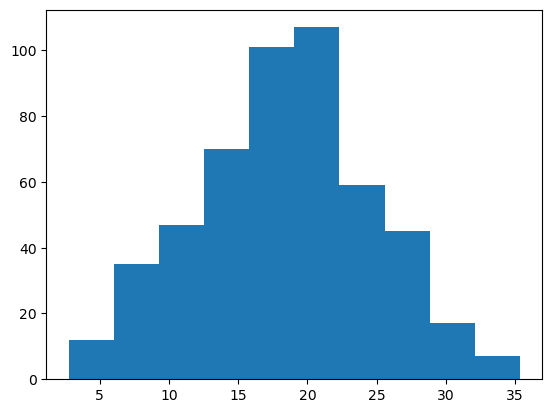

In [82]:
import matplotlib.pyplot as plt
plt.hist(sample_diffs)
#Seems to fit normal distribution

Export games with lines so shelve doesn't need to be used, also export transformed training data for reuse

In [83]:
df.to_csv('all seasons with lines.csv', index=False)
data.to_csv('transformed_training_data.csv', index=False)
predictions.to_csv('predictions.csv', index=False)
